# **IMPORTS**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install keras_lr_finder
from keras_lr_finder import LRFinder

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
train_df = pd.read_excel('/content/drive/My Drive/Files-Covid/train.xlsx')
test_df = pd.read_excel('/content/drive/My Drive/Files-Covid/test.xlsx')
valid_df = pd.read_excel('/content/drive/My Drive/Files-Covid/valid.xlsx')

In [ ]:
test_df.head()

,Source,Covid
0,2020.03.22.20040782-p25-1542.png,1
1,2020.03.22.20040782-p25-1543.png,1
2,2020.03.22.20040782-p25-1544.png,1
3,2020.03.22.20040782-p25-1545.png,1
4,2020.03.22.20040782-p25-1546.png,1


In [ ]:
labels = ['Covid']
np.random.seed(1337)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
# from tensdorflow.keras.applications.resnet152 import 
from keras.layers import Dense, GlobalAveragePooling2D,Flatten,Dropout
from keras.models import Model
from keras import backend as K
from keras.models import load_model
import keras

# **DATA GENERATOR**

In [ ]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 200, target_h =200):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [ ]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 200, target_h = 200):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMG_DIR, 
        x_col="Source", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [ ]:
IMG_DIR = "/content/drive/My Drive/Files-Covid/IMG_DIR/"
train_generator_48 = get_train_generator(train_df, IMG_DIR, "Source", labels,target_w = 48, target_h = 48)
valid_generator_48, test_generator_48= get_test_and_valid_generator(valid_df, test_df, train_df, IMG_DIR, "Source", labels, target_w = 48, target_h = 48)
train_generator_96 = get_train_generator(train_df, IMG_DIR, "Source", labels,target_w = 96, target_h = 96)
valid_generator_96, test_generator_96= get_test_and_valid_generator(valid_df, test_df, train_df, IMG_DIR, "Source", labels, target_w = 96, target_h = 96)

getting train generator...
Found 425 validated image filenames.
getting train and valid generators...
Found 425 validated image filenames.
Found 118 validated image filenames.
Found 203 validated image filenames.
getting train generator...
Found 425 validated image filenames.
getting train and valid generators...
Found 425 validated image filenames.
Found 118 validated image filenames.
Found 203 validated image filenames.


In [ ]:
train_generator_192 = get_train_generator(train_df, IMG_DIR, "Source", labels,target_w = 192, target_h = 192)
valid_generator_192, test_generator_192= get_test_and_valid_generator(valid_df, test_df, train_df, IMG_DIR, "Source", labels, target_w = 192, target_h = 192)

getting train generator...
Found 425 validated image filenames.
getting train and valid generators...
Found 425 validated image filenames.
Found 118 validated image filenames.
Found 203 validated image filenames.


# **DATA EXPLORATION**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


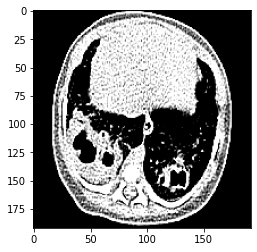

In [ ]:
x, y = train_generator_192.__getitem__(10)
plt.imshow(x[0]);

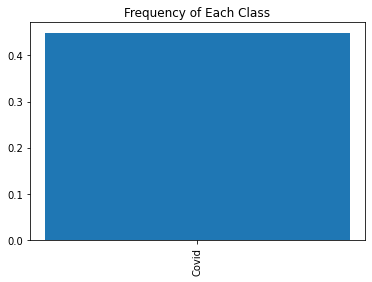

In [ ]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator_48.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [ ]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels,axis=0)/N
    negative_frequencies = np.ones_like(positive_frequencies) - positive_frequencies

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [ ]:
freq_pos, freq_neg = compute_class_freqs(train_generator_48.labels)
print(freq_pos)
print(freq_neg)

[0.44941176]
[0.55058824]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


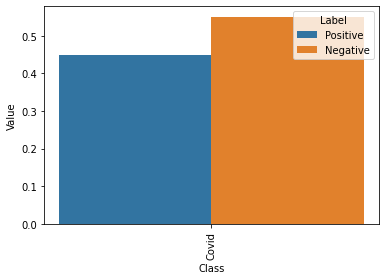

In [ ]:
import seaborn as sns
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [ ]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

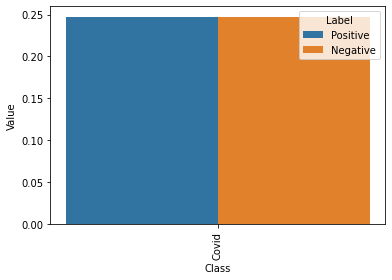

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

# **MODEL**

In [ ]:
from keras.callbacks import Callback
from keras import backend as K
import numpy as np


class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency.
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.

    The amplitude of the cycle can be scaled on a per-iteration or
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each
        cycle iteration.
    For more detail, please see paper.

    # Example for CIFAR-10 w/ batch size 100:
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```

    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```

    # References

      - [Cyclical Learning Rates for Training Neural Networks](
      https://arxiv.org/abs/1506.01186)
    """

    def __init__(
            self,
            base_lr=0.001,
            max_lr=0.006,
            step_size=2000.,
            mode='triangular',
            gamma=1.,
            scale_fn=None,
            scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        if mode not in ['triangular', 'triangular2',
                        'exp_range']:
            raise KeyError("mode must be one of 'triangular', "
                           "'triangular2', or 'exp_range'")
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2.**(x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** x
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr is not None:
            self.base_lr = new_base_lr
        if new_max_lr is not None:
            self.max_lr = new_max_lr
        if new_step_size is not None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())

        self.history.setdefault(
            'lr', []).append(
            K.get_value(
                self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [ ]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Tensor): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += -K.mean(pos_weights[i]*y_true[:,i]*K.log(y_pred[:,i]+epsilon) + neg_weights[i]*(1-y_true[:,i])*K.log(1-y_pred[:,i]+epsilon)) 
        return loss
    return weighted_loss

In [ ]:
# import tensorflow.keras.losses
# keras.losses.custom_loss = weighted_loss

In [ ]:
# create the base pre-trained model
prior = keras.applications.VGG19(weights='imagenet', input_shape=(192,192,3), include_top=False)

model = keras.models.Sequential()
model.add(prior)
# add a global spatial average pooling layer
model.add(keras.layers.AveragePooling2D(pool_size=(2,2),strides=(1,1),padding='valid'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024,kernel_regularizer=keras.regularizers.l1_l2()))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(512,kernel_regularizer=keras.regularizers.l1_l2()))
model.add(keras.layers.Dense(256,kernel_regularizer=keras.regularizers.l1_l2()))
model.add(keras.layers.Dense(128,kernel_regularizer=keras.regularizers.l1_l2()))
# and a logistic layer
model.add(keras.layers.Dense(len(labels), activation="sigmoid"))

#freeze layers
for cnn_block_layer in model.layers[0].layers:
    cnn_block_layer.trainable = False
model.layers[0].trainable = False

# model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2), loss=get_weighted_loss(pos_weights,neg_weights),metrics=['accuracy'])
# clr = CyclicLR(base_lr=0.01, max_lr=0.06,
#                     step_size=2000., mode='triangular')

# tf.keras.backend.clear_session()

In [ ]:
# !pip install tensorflow==1.14.0

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(4, 192, 192, 3)
Epoch 1/1000
4/4 [==============================] - 0s 97ms/step - loss: 1638.7488 - accuracy: 0.7500
Epoch 2/1000
4/4 [==============================] - 0s 14ms/step - loss: 1639.1077 - accuracy: 0.2500
Epoch 3/1000
4/4 [==============================] - 0s 15ms/step - loss: 1639.3342 - accuracy: 0.5000
Epoch 4/1000
4/4 [==============================] - 0s 14ms/step - loss: 1638.9198 - accuracy: 0.7500
Epoch 5/1000
4/4 [==============================] - 0s 14ms/step - loss: 1639.0616 - accuracy: 0.5000
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 1639.0300 - accuracy: 0.5000
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 1639.3154 - accuracy: 0.5000
Epoch 8/1000
4/4 [==============================] - 0s 13ms/step - loss: 1639.3392 - accuracy: 0.5000
Epoch 9/1000
4/4 [==============================] - 0s 14ms/step - loss: 1639.0228 - accuracy: 0.5000
Epoch 10/1000
4/4 [==============================] - 0s 13ms/step

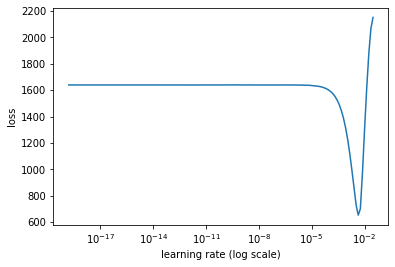

In [ ]:
X_batch, y_batch = next(train_generator_192)
X_idxs_resampled, _ = RandomUnderSampler().fit_resample(
    np.asarray(range(len(X_batch)))[:, np.newaxis], 
    y_batch
)

X_batch, y_batch = X_batch[X_idxs_resampled[:, 0]], y_batch[X_idxs_resampled[:, 0]]
print(X_batch.shape)
lr_finder = LRFinder(model)
lr_finder.find(X_batch, y_batch, start_lr=1e-20, end_lr=1e+10, batch_size=16, epochs=1000)
lr_finder.plot_loss()

In [ ]:
history = model.fit_generator(train_generator_192, 
                              validation_data=valid_generator_192,
                              steps_per_epoch=500, 
                              validation_steps=50, 
                              epochs = 100,
                              verbose=1,
                              callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=10,verbose=1,restore_best_weights = True),keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Files-Covid/.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')])

model.save("/content/drive/My Drive/Files-Covid/model48.h5")

Epoch 1/100
 30/500 [>.............................] - ETA: 39s - loss: 6.2009 - accuracy: 0.5708

KeyboardInterrupt: ignored

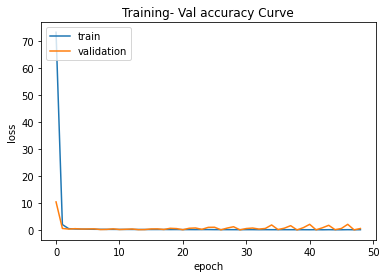

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training- Val accuracy Curve")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(64,kernel_size=(3,3),input_shape = (96,96,3),padding='same',activation='relu'))
model.add(keras.layers.Conv2D(64,kernel_size=(3,3),input_shape=(96,96,3),padding='same',activation='relu'))
model.add(keras.layers.Conv2D(64,kernel_size=(3,3),input_shape=(96,96,3),padding='same',activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
print("first model")
model.summary()
prior = keras.models.load_model("/content/drive/My Drive/Files-Covid/model48.h5", custom_objects={'weighted_loss': get_weighted_loss(pos_weights,neg_weights,epsilon=1e-07)})


for layer in prior.layers[0].layers[2:]:
    model.add(layer)
print("second step")
model.summary()
# re-add the feedforward layers on top
for layer in prior.layers[1:]:
    model.add(layer)
print("third step")
model.summary()
# the pretrained CNN layers are already marked non-trainable
# mark off the top layers as well
for layer in prior.layers[-16:]:
    layer.trainable = False
print("fourth step")
model.summary()
model.compile(optimizer=keras.optimizers.Adam(), loss=get_weighted_loss(pos_weights, neg_weights),metrics=['accuracy'])
# clr = CyclicLR(base_lr=0.01, max_lr=0.06,
#                     step_size=2000., mode='triangular2')



first model
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 96, 96, 64)        1792      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 96, 96, 64)        36928     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 96, 96, 64)        36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 96, 96, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 48, 64)        0         
Total params: 75,904
Trainable params: 75,776
Non-trainable params: 128
_________________________________________________________________
second step
Model: "sequential_9"
_________________________________________________________________
La

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(6, 96, 96, 3)
Epoch 1/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.0222 - accuracy: 0.5000
Epoch 2/1000
6/6 [==============================] - 0s 7ms/step - loss: 2.0224 - accuracy: 0.5000
Epoch 3/1000
6/6 [==============================] - 0s 6ms/step - loss: 2.6782 - accuracy: 0.3333
Epoch 4/1000
6/6 [==============================] - 0s 6ms/step - loss: 1.8999 - accuracy: 0.5000
Epoch 5/1000
6/6 [==============================] - 0s 6ms/step - loss: 1.9489 - accuracy: 0.5000
Epoch 6/1000
6/6 [==============================] - 0s 7ms/step - loss: 1.9516 - accuracy: 0.5000
Epoch 7/1000
6/6 [==============================] - 0s 6ms/step - loss: 2.6714 - accuracy: 0.3333
Epoch 8/1000
6/6 [==============================] - 0s 6ms/step - loss: 1.4132 - accuracy: 0.3333
Epoch 9/1000
6/6 [==============================] - 0s 6ms/step - loss: 2.4538 - accuracy: 0.3333
Epoch 10/1000
6/6 [==============================] - 0s 6ms/step - loss: 1.1308 - accuracy: 0.3333
Epoc

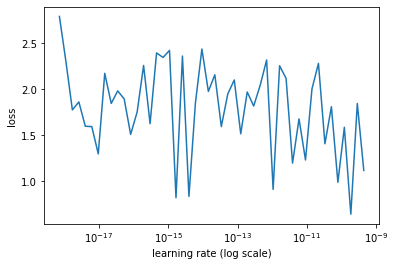

In [ ]:
X_batch, y_batch = next(train_generator_96)
X_idxs_resampled, _ = RandomUnderSampler().fit_resample(
    np.asarray(range(len(X_batch)))[:, np.newaxis], 
    y_batch
)

X_batch, y_batch = X_batch[X_idxs_resampled[:, 0]], y_batch[X_idxs_resampled[:, 0]]
print(X_batch.shape)
lr_finder = LRFinder(model)
lr_finder.find(X_batch, y_batch, start_lr=1e-20, end_lr=1e+50, batch_size=16, epochs=1000)
lr_finder.plot_loss()

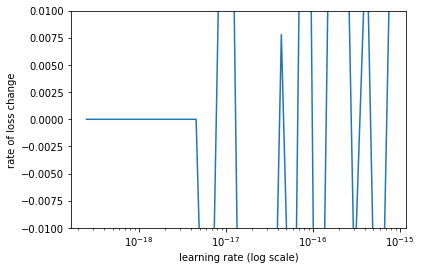

In [ ]:
lr_finder.plot_loss_change(sma=20, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01))

In [ ]:
history = model.fit_generator(train_generator_96, 
                              validation_data=valid_generator_96,
                              steps_per_epoch=200, 
                              validation_steps=100, 
                              epochs = 100,
                              verbose=1,
                              callbacks = [keras.callbacks.EarlyStopping(patience=10,verbose=1,restore_best_weights = True),keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Files-Covid/.mdl_96_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')])

model.save("/content/drive/My Drive/Files-Covid/model96.h5")

Epoch 1/100
200/200 [==============================] - 16s 80ms/step - loss: 1.2988 - accuracy: 0.5948 - val_loss: 2.0955 - val_accuracy: 0.4162
Epoch 2/100
200/200 [==============================] - 16s 81ms/step - loss: 0.9485 - accuracy: 0.6298 - val_loss: 4.5784 - val_accuracy: 0.3830
Epoch 3/100
200/200 [==============================] - 16s 78ms/step - loss: 0.7912 - accuracy: 0.6453 - val_loss: 0.8756 - val_accuracy: 0.3982
Epoch 4/100
200/200 [==============================] - 15s 77ms/step - loss: 0.7330 - accuracy: 0.6616 - val_loss: 3.2801 - val_accuracy: 0.4378
Epoch 5/100
200/200 [==============================] - 16s 80ms/step - loss: 0.7854 - accuracy: 0.6580 - val_loss: 3.0225 - val_accuracy: 0.5127
Epoch 6/100
200/200 [==============================] - 16s 78ms/step - loss: 0.6080 - accuracy: 0.7055 - val_loss: 3.3554 - val_accuracy: 0.4593
Epoch 7/100
200/200 [==============================] - 15s 76ms/step - loss: 0.5810 - accuracy: 0.7169 - val_loss: 2.2881 - val_ac

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(16,kernel_size=(3,3),input_shape = (192,192,3),padding='same',activation='relu'))
model.add(keras.layers.Conv2D(16,kernel_size=(3,3),input_shape = (192,192,3),padding='same',activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32,kernel_size=(3,3),input_shape = (192,192,3),padding='same',activation='relu'))
model.add(keras.layers.Conv2D(32,kernel_size=(3,3),input_shape = (192,192,3),padding='same',activation='relu'))
model.add(keras.layers.Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.summary()
prior = keras.models.load_model("/content/drive/My Drive/Files-Covid/model96.h5", custom_objects={'weighted_loss': get_weighted_loss(pos_weights,neg_weights,epsilon=1e-07)})
prior.summary()
# for layer in prior.layers[0].layers[2:]:
#   model.add(layer)
for layer in prior.layers[1:]:
    layer.name += '_prior'  # set layer names to avoid name collisions
    model.add(layer)

# the pretrained CNN layers are already marked non-trainable
# mark off the top layers as well
for layer in model.layers[-16:]:
    layer.trainable = False
    
# set layer names (otherwise names may collide)
for i, layer in enumerate(model.layers):
    layer.name = 'layer_' + str(i)


model.compile(optimizer=keras.optimizers.Adam(), loss=get_weighted_loss(pos_weights, neg_weights),metrics=['accuracy'])
# clr = CyclicLR(base_lr=0.01, max_lr=0.06,
#                     step_size=2000., mode='triangular2')


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 192, 192, 16)      448       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 192, 192, 16)      2320      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 192, 192, 32)      4640      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 192, 192, 32)      9248      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 192, 192, 64)      18496     
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 192, 192, 64)      36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 192, 192, 64)    

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(6, 192, 192, 3)
Epoch 1/200
6/6 [==============================] - 0s 17ms/step - loss: 1.6311 - accuracy: 0.3333
Epoch 2/200
6/6 [==============================] - 0s 17ms/step - loss: 2.1368 - accuracy: 0.5000
Epoch 3/200
6/6 [==============================] - 0s 17ms/step - loss: 1.3262 - accuracy: 0.6667
Epoch 4/200
6/6 [==============================] - 0s 17ms/step - loss: 1.6658 - accuracy: 0.5000
Epoch 5/200
6/6 [==============================] - 0s 17ms/step - loss: 1.3181 - accuracy: 0.5000
Epoch 6/200
6/6 [==============================] - 0s 17ms/step - loss: 2.6916 - accuracy: 0.5000
Epoch 7/200
6/6 [==============================] - 0s 17ms/step - loss: 2.0903 - accuracy: 0.3333
Epoch 8/200
6/6 [==============================] - 0s 17ms/step - loss: 1.2824 - accuracy: 0.6667
Epoch 9/200
6/6 [==============================] - 0s 17ms/step - loss: 1.1346 - accuracy: 0.3333
Epoch 10/200
6/6 [==============================] - 0s 17ms/step - loss: 1.6001 - accuracy: 0.5000
Ep

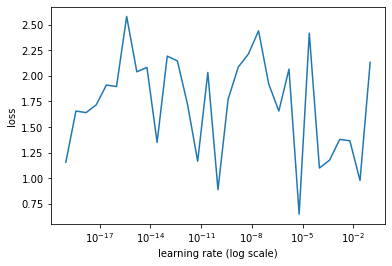

In [ ]:
X_batch, y_batch = next(train_generator_192)
X_idxs_resampled, _ = RandomUnderSampler().fit_resample(
    np.asarray(range(len(X_batch)))[:, np.newaxis], 
    y_batch
)

X_batch, y_batch = X_batch[X_idxs_resampled[:, 0]], y_batch[X_idxs_resampled[:, 0]]
print(X_batch.shape)
lr_finder = LRFinder(model)
lr_finder.find(X_batch, y_batch, start_lr=1e-25, end_lr=1e+20, batch_size=16, epochs=200)
lr_finder.plot_loss()

In [ ]:
history = model.fit_generator(train_generator_192, 
                              validation_data=valid_generator_192,
                              steps_per_epoch=200, 
                              validation_steps=100, 
                              epochs = 100,
                              verbose=1,
                              callbacks = [keras.callbacks.EarlyStopping(patience=10,verbose=1,restore_best_weights = True),keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Files-Covid/.mdl_96_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')])

model.save("/content/drive/My Drive/Files-Covid/model128.h5")
# tf.keras.backend.clear_session()

Epoch 1/100
200/200 [==============================] - 32s 160ms/step - loss: 0.8189 - accuracy: 0.6238 - val_loss: 0.2479 - val_accuracy: 0.4695
Epoch 2/100
200/200 [==============================] - 31s 157ms/step - loss: 0.5321 - accuracy: 0.7272 - val_loss: 6.6683 - val_accuracy: 0.5954
Epoch 3/100
200/200 [==============================] - 32s 158ms/step - loss: 0.4889 - accuracy: 0.7441 - val_loss: 0.1287 - val_accuracy: 0.5611
Epoch 4/100
200/200 [==============================] - 31s 157ms/step - loss: 0.6213 - accuracy: 0.6927 - val_loss: 1.3348 - val_accuracy: 0.5140
Epoch 5/100
200/200 [==============================] - 31s 157ms/step - loss: 0.4679 - accuracy: 0.7519 - val_loss: 7.3593 - val_accuracy: 0.5547
Epoch 6/100
200/200 [==============================] - 31s 157ms/step - loss: 0.4514 - accuracy: 0.7562 - val_loss: 1.3554 - val_accuracy: 0.5649
Epoch 7/100
200/200 [==============================] - 31s 156ms/step - loss: 0.3845 - accuracy: 0.7952 - val_loss: 1.0215 -

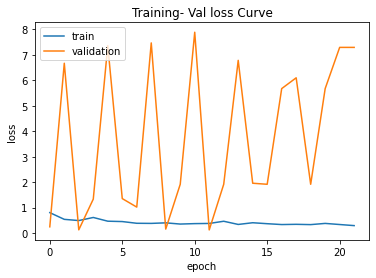

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training- Val loss Curve")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# **METRICS**

In [ ]:
predicted_vals = model.predict_generator(test_generator_192, steps = len(test_generator_192))

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

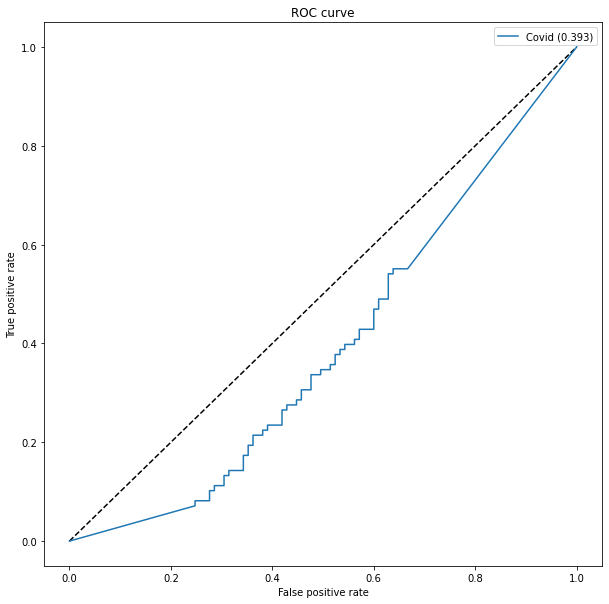

In [ ]:
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator_192)

In [ ]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity

In [ ]:
def get_mean_std_per_batch(image_path, df, H=200, W=200):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Source"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std
def load_image(img, image_dir, df, preprocess=True, H=200, W=200):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

def grad_cam(input_model, image, cls, layer_name, H=200, W=200):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
                    layer_name='conv5_block3_2_bn'):
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),
                       cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1

In [ ]:
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])

In [ ]:
IMG_DIR = "/content/drive/My Drive/Files-Covid/IMG_DIR/"
compute_gradcam(model,'2020.03.26.20041426-p11-128.png', IMG_DIR, test_df, labels, labels_to_show)

In [ ]:
labels

In [ ]:
class_labes = ['Covid']
pred_labels = ['Covid_pred']

In [ ]:
def true_positives(y, pred, th=0.4):
    """
    Count true positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TP (int): true positives
    """
    TP = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    # compute TP
    TP = np.sum((y == 1) & (thresholded_preds == 1))
    
    return TP

def true_negatives(y, pred, th=0.4):
    """
    Count true negatives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TN (int): true negatives
    """
    TN = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute TN
    TN =  np.sum((y == 0) & (thresholded_preds == 0))
    
    ### END CODE HERE ###
    
    return TN

def false_positives(y, pred, th=0.4):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FP (int): false positives
    """
    FP = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # compute FP
    FP =  np.sum((y == 0) & (thresholded_preds == 1))
    
    ### END CODE HERE ###
    
    return FP

def false_negatives(y, pred, th=0.4):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FN (int): false negatives
    """
    FN = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute FN
    FN =  np.sum((y == 1) & (thresholded_preds == 0))
    
    ### END CODE HERE ###
    
    return FN

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)


def get_true_pos(y, pred, th=0.4):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def get_true_neg(y, pred, th=0.4):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def get_false_neg(y, pred, th=0.4):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))


def get_false_pos(y, pred, th=0.4):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))


def get_performance_metrics(y, pred, class_labels, tp=get_true_pos,
                            tn=get_true_neg, fp=get_false_pos,
                            fn=get_false_neg,
                            acc=None, prevalence=None, spec=None,
                            sens=None, ppv=None, npv=None, auc=None, f1=None,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.4] * len(class_labels)

    columns = ["", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [""] + [0] * (len(columns) - 1)
        df.loc[i][0] = class_labels[i]
        df.loc[i][1] = round(tp(y[:, i], pred[:, i]),
                             3) if tp != None else "Not Defined"
        df.loc[i][2] = round(tn(y[:, i], pred[:, i]),
                             3) if tn != None else "Not Defined"
        df.loc[i][3] = round(fp(y[:, i], pred[:, i]),
                             3) if fp != None else "Not Defined"
        df.loc[i][4] = round(fn(y[:, i], pred[:, i]),
                             3) if fn != None else "Not Defined"
        df.loc[i][5] = round(acc(y[:, i], pred[:, i], thresholds[i]),
                             3) if acc != None else "Not Defined"
        df.loc[i][6] = round(prevalence(y[:, i]),
                             3) if prevalence != None else "Not Defined"
        df.loc[i][7] = round(sens(y[:, i], pred[:, i], thresholds[i]),
                             3) if sens != None else "Not Defined"
        df.loc[i][8] = round(spec(y[:, i], pred[:, i], thresholds[i]),
                             3) if spec != None else "Not Defined"
        df.loc[i][9] = round(ppv(y[:, i], pred[:, i], thresholds[i]),
                             3) if ppv != None else "Not Defined"
        df.loc[i][10] = round(npv(y[:, i], pred[:, i], thresholds[i]),
                              3) if npv != None else "Not Defined"
        df.loc[i][11] = round(auc(y[:, i], pred[:, i]),
                              3) if auc != None else "Not Defined"
        df.loc[i][12] = round(f1(y[:, i], pred[:, i] > thresholds[i]),
                              3) if f1 != None else "Not Defined"
        df.loc[i][13] = round(thresholds[i], 3)

    df = df.set_index("")
    return df


def print_confidence_intervals(class_labels, statistics):
    df = pd.DataFrame(columns=["Mean AUC (CI 5%-95%)"])
    for i in range(len(class_labels)):
        mean = statistics.mean(axis=1)[i]
        max_ = np.quantile(statistics, .95, axis=1)[i]
        min_ = np.quantile(statistics, .05, axis=1)[i]
        df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
    return df


def get_curve(gt, pred, target_names, curve='roc'):
    for i in range(len(target_names)):
        if curve == 'roc':
            curve_function = roc_curve
            auc_roc = roc_auc_score(gt[:, i], pred[:, i])
            label = target_names[i] + " AUC: %.3f " % auc_roc
            xlabel = "False positive rate"
            ylabel = "True positive rate"
            a, b, _ = curve_function(gt[:, i], pred[:, i])
            plt.figure(1, figsize=(7, 7))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(a, b, label=label)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)

            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        elif curve == 'prc':
            precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
            average_precision = average_precision_score(gt[:, i], pred[:, i])
            label = target_names[i] + " Avg.: %.3f " % average_precision
            plt.figure(1, figsize=(7, 7))
            plt.step(recall, precision, where='post', label=label)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)

In [ ]:
df1 = pd.DataFrame(test_generator.labels, columns= ['Covid'])

In [ ]:
df1.head()

In [ ]:
df2 = pd.DataFrame(predicted_vals,columns=['Covid_pred'])

In [ ]:
df = [df1 , df2]

result = pd.concat(df,axis=1)

In [ ]:
result

In [ ]:
y = result[class_labes].values
pred = result[pred_labels].values

In [ ]:
result[np.concatenate([class_labes, pred_labels])].head()

In [ ]:
get_performance_metrics(y, pred, class_labes)

In [ ]:
def get_accuracy(y, pred, th=0.5):
    """
    Compute accuracy of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        accuracy (float): accuracy of predictions at threshold
    """
    accuracy = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TP, FP, TN, FN using our previously defined functions
    TP = true_positives(y,pred,th=0.5)
    FP = false_positives(y,pred, th=0.5)
    TN = true_negatives(y, pred, th=0.5)
    FN = false_negatives(y, pred, th=0.5)

    # Compute accuracy using TP, FP, TN, FN
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    
    ### END CODE HERE ###
    
    return accuracy

In [ ]:
get_performance_metrics(y, pred, class_labes, acc=get_accuracy)

In [ ]:
get_accuracy(result["Covid"].values, np.zeros(len(result)))

In [ ]:
def get_prevalence(y):
    """
    Compute accuracy of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
    Returns:
        prevalence (float): prevalence of positive cases
    """
    prevalence = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    prevalence = np.mean(y)
    
    ### END CODE HERE ###
    
    return prevalence

In [ ]:
get_performance_metrics(y, pred, class_labes, acc=get_accuracy, prevalence=get_prevalence)

In [ ]:
def get_sensitivity(y, pred, th=0.5):
    """
    Compute sensitivity of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        sensitivity (float): probability that our test outputs positive given that the case is actually positive
    """
    sensitivity = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TP and FN using our previously defined functions
    TP = true_positives(y,pred, th =0.5)
    FN = false_negatives(y,pred, th=0.5)

    # use TP and FN to compute sensitivity
    sensitivity = TP / (TP+FN)
    
    ### END CODE HERE ###
    
    return sensitivity

def get_specificity(y, pred, th=0.5):
    """
    Compute specificity of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        specificity (float): probability that the test outputs negative given that the case is actually negative
    """
    specificity = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TN and FP using our previously defined functions
    TN = true_negatives(y,pred,th=0.5)
    FP = false_positives(y,pred, th=0.5)
    
    # use TN and FP to compute specificity 
    specificity = TN / (TN+FP)
    
    ### END CODE HERE ###
    
    return specificity

In [ ]:
get_performance_metrics(y, pred, class_labes, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity)

In [ ]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_ppv(y, pred, th=0.5):
    """
    Compute PPV of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        PPV (float): positive predictive value of predictions at threshold
    """
    PPV = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TP and FP using our previously defined functions
    TP = true_positives(y,pred,th=0.5)
    FP = false_positives(y,pred, th =0.5)

    # use TP and FP to compute PPV
    PPV = TP / (TP+FP)
    
    ### END CODE HERE ###
    
    return PPV

def get_npv(y, pred, th=0.5):
    """
    Compute NPV of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        NPV (float): negative predictive value of predictions at threshold
    """
    NPV = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TN and FN using our previously defined functions
    TN = true_negatives(y,pred,th=0.5)
    FN = false_negatives(y,pred,th=0.5)

    # use TN and FN to compute NPV
    NPV = TN / (FN+TN)
    
    ### END CODE HERE ###
    
    return NPV

In [ ]:
get_performance_metrics(y, pred, class_labes, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv)

In [ ]:
get_curve(y, pred, class_labes)

In [ ]:
from sklearn.metrics import roc_auc_score
get_performance_metrics(y, pred, class_labes, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score)

In [ ]:
def bootstrap_auc(y, pred, classes, bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))

    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y[:, c]
        df.loc[:, 'pred'] = pred[:, c]
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = roc_auc_score(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics

statistics = bootstrap_auc(y, pred, class_labes)

In [ ]:
print_confidence_intervals(class_labes, statistics)

In [ ]:
get_curve(y, pred, class_labes, curve='prc')

In [ ]:
from sklearn.metrics import f1_score
get_performance_metrics(y, pred, class_labes, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
from sklearn.calibration import calibration_curve
def plot_calibration_curve(y, pred):
    plt.figure(figsize=(20, 20))
    for i in range(len(class_labes)):
        plt.subplot(4, 4, i + 1)
        fraction_of_positives, mean_predicted_value = calibration_curve(y[:,i], pred[:,i], n_bins=20)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(mean_predicted_value, fraction_of_positives, marker='.')
        plt.xlabel("Predicted Value")
        plt.ylabel("Fraction of Positives")
        plt.title(class_labes[i])
    plt.tight_layout()
    plt.show()

In [ ]:
plot_calibration_curve(y, pred)